In [1]:
import torch
from torch import nn
from mamba_ssm import Mamba

/home/whalenlex/.local/share/virtualenvs/mamba-segment-2sIU9SJh/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
from glob import glob
import pandas as pd 
import cv2
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16_bn
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
# function to create dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')
    print(masks_paths)

    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))

    df = pd.DataFrame(data= {'images_paths': images_paths, 'masks_paths': masks_paths})

    return df

# Function to split dataframe into train, valid, test
def split_df(df):
    # create train_df
    train_df, dummy_df = train_test_split(df, train_size= 0.8)

    # create valid_df and test_df
    valid_df, test_df = train_test_split(dummy_df, train_size= 0.5)

    return train_df, valid_df, test_df

In [8]:
data_path = "../datasets/tumor_segs/"
df = create_df(data_path)
train_df, val_df, test_df = split_df(df)

['../datasets/tumor_segs/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_25_mask.tif', '../datasets/tumor_segs/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_46_mask.tif', '../datasets/tumor_segs/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_57_mask.tif', '../datasets/tumor_segs/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_48_mask.tif', '../datasets/tumor_segs/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_11_mask.tif', '../datasets/tumor_segs/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_33_mask.tif', '../datasets/tumor_segs/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_38_mask.tif', '../datasets/tumor_segs/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_22_mask.tif', '../datasets/tumor_segs/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_18_mask.tif', '../datasets/tumor_segs/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_41_mask.tif', '../datasets/tumor_segs/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_32_mask.tif', '../datasets/tumor_segs/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_55_mask.tif', '../datasets/tu

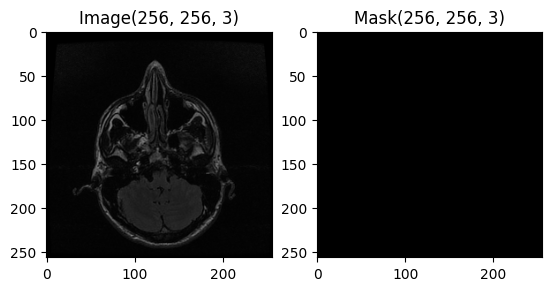

In [9]:
image = cv2.imread(train_df.iloc[5, 0]) / 255.0
mask = cv2.imread(train_df.iloc[5, 1]) / 255.0
mask = np.where(mask>=0.5, 1., 0.)

plt.subplot(1,2,1)
plt.imshow(image)
plt.title('Image'+str(image.shape))
plt.subplot(1,2,2)
plt.imshow(mask)
plt.title('Mask'+str(mask.shape))
plt.show()

In [10]:
class Brain_mri_dataset(torch.utils.data.Dataset):
    def __init__(self, dataframe  ,  transform = None ,  mask_transform= None):
        self.df = dataframe #pd.read_csv(annotations_file)
        self.transform = transform
        self.mask_transform = mask_transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self , idx):
        image = cv2.imread(self.df.iloc[idx, 0]) / 255.0
        mask = cv2.imread(self.df.iloc[idx, 1])  / 255.0
        mask = np.where(mask>=0.5, 1., 0.)
        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        return image, mask

In [11]:
transform_ = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

val_data = Brain_mri_dataset(val_df, transform = transform_ ,  mask_transform= transform_)

# batch
batch_size =64

In [12]:
# def IOU(y_true, y_pred, smooth=1e-5):
#     intersection = (y_true * y_pred).sum()
#     union = (y_true + y_pred).sum() - intersection + smooth
#     iou = (intersection + smooth) / union
#     return iou
def calculate_iou(pred_mask, true_mask):
    intersection = torch.logical_and(pred_mask, true_mask).sum()
    union = torch.logical_or(pred_mask, true_mask).sum()

    iou = intersection / union if union != 0 else 0.0
    return iou

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
from mamba_model import UMambaBot

In [19]:
model = UMambaBot(
    input_channels=3,  # Assuming RGB images with 3 channels
    n_stages=5,
    features_per_stage=(32, 64, 128, 256,512),
    conv_op=nn.Conv2d,  # Assuming 2D convolution
    kernel_sizes=(3, 3, 3, 3, 3),  # Adjusted kernel sizes for 2D convolution
    strides=(1, 2, 2, 2, 2),
    num_classes=3,
    n_conv_per_stage=(1, 1, 1, 1, 1),
    n_conv_per_stage_decoder=(1, 1, 1, 1),
    conv_bias=True,
    norm_op=nn.InstanceNorm2d,  # Assuming 2D instance normalization
    norm_op_kwargs={},
    dropout_op=None,
    nonlin=nn.LeakyReLU,
    nonlin_kwargs={'inplace': True},
    # Pyramidal Pooling
    ppm_pool_sizes=(1,2,3,6)
).to(device)

In [20]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters: {total_params}')
print(f'Trainable parameters: {trainable_params}')

Total parameters: 10077324
Trainable parameters: 10077324


In [21]:
model.load_state_dict(torch.load('mamba_pipeline_py_weights.pth'))
model.eval()

UMambaBot(
  (encoder): ResidualEncoder(
    (stem): StackedConvBlocks(
      (convs): Sequential(
        (0): ConvDropoutNormReLU(
          (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
          (nonlin): LeakyReLU(negative_slope=0.01, inplace=True)
          (all_modules): Sequential(
            (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
            (2): LeakyReLU(negative_slope=0.01, inplace=True)
          )
        )
      )
    )
    (stages): Sequential(
      (0): StackedResidualBlocks(
        (blocks): Sequential(
          (0): BasicBlockD(
            (conv1): ConvDropoutNormReLU(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (norm): InstanceNorm2d(32, eps=1e-0

In [23]:
# dataloader
val_data_loader = DataLoader(val_data,batch_size=64,shuffle=True)

In [24]:
def calculate_iou(pred_mask, true_mask):
    intersection = torch.logical_and(pred_mask, true_mask).sum()
    union = torch.logical_or(pred_mask, true_mask).sum()

    iou = intersection / union if union != 0 else 0.0
    return iou

def show_sample(data, n=2):
    imgs, true_masks = data
    results = model(imgs.to(device).float()).cpu()
    results = torch.where(results >= 0.6, 1.0, 0.0)

    fig, axs = plt.subplots(3, n, figsize=(n * 3, 9))
    for i in range(n):
        axs[0, i].imshow(imgs[i].permute(1, 2, 0))
        axs[0, i].set_title("Input Image")

        axs[1, i].imshow(results[i].permute(1, 2, 0))
        axs[1, i].set_title("Predicted Mask")

        axs[2, i].imshow(true_masks[i].permute(1, 2, 0))
        axs[2, i].set_title("True Mask")

        # Calculate and display IoU score
        iou_score = calculate_iou(results[i], true_masks[i])
        axs[2, i].set_xlabel(f"IoU: {iou_score:.4f}")

    fig.suptitle('Results Sample')
    fig.tight_layout()
    fig.show()
    fig.savefig('test.png')


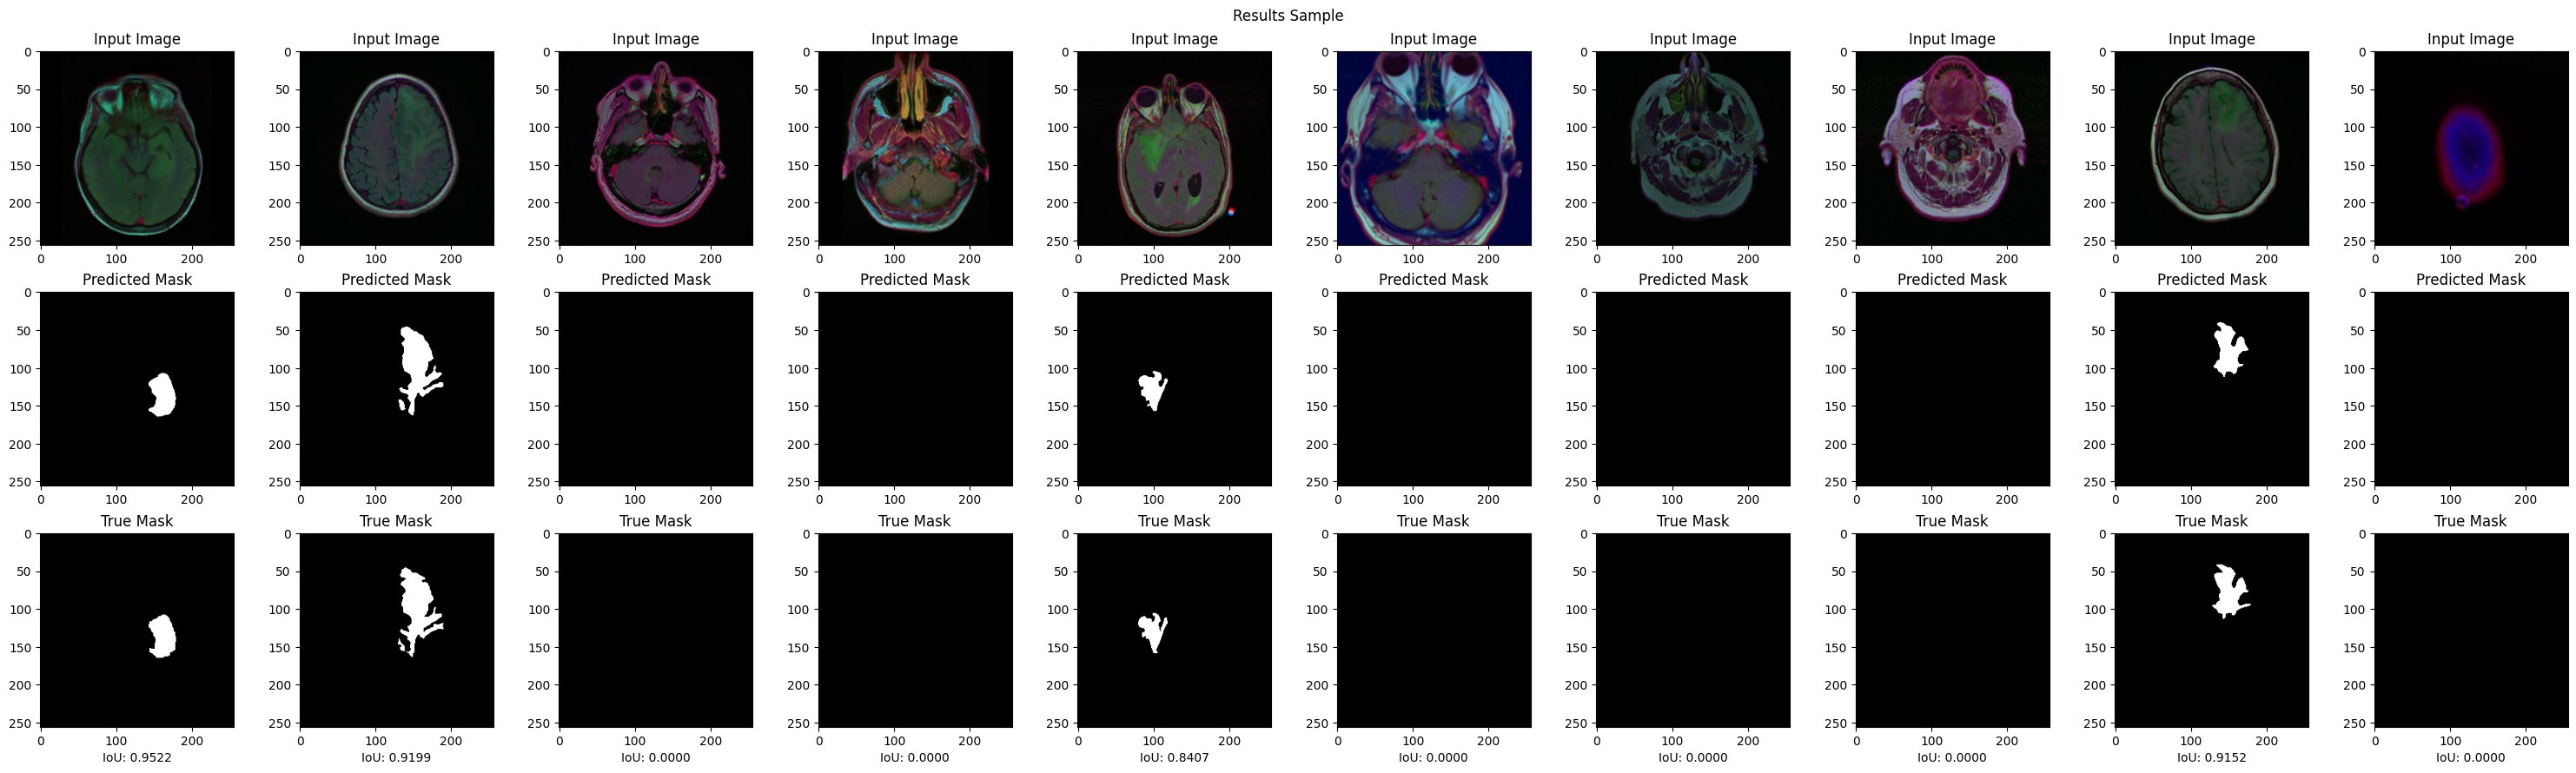

In [27]:
show_sample(next(iter(val_data_loader)),5)